In [1]:
import numpy as np
import pandas as pd
import random
import glob
import math
import xgboost
from sklearn import preprocessing

from matplotlib import pyplot


In [2]:
# Get list of files for the Geo grouped data
data_files_list = glob.glob('/datasets/cms/MUP*Geo.csv')
data_files_list

# For training use 2013 to 2016 to predict 2017
# For testing use 2014 to 2017 to predict 2018
# for validation use 2015 to 2018 to predict 2019

# For presentation use 2016 to 2019 to predict 2020 (and compare against 2019)

['/datasets/cms/MUP_PHY_R19_P04_V10_D13_Geo.csv',
 '/datasets/cms/MUP_PHY_R19_P04_V10_D14_Geo.csv',
 '/datasets/cms/MUP_PHY_R19_P04_V10_D15_Geo.csv',
 '/datasets/cms/MUP_PHY_R19_P04_V10_D16_Geo.csv',
 '/datasets/cms/MUP_PHY_R19_P04_V10_D17_Geo.csv',
 '/datasets/cms/MUP_PHY_R20_P04_V10_D18_Geo.csv',
 '/datasets/cms/MUP_PHY_R21_P04_V10_D19_Geo.csv']

In [3]:
df_geo_full = []
for _file in data_files_list:
    df_geo = pd.read_csv(
         _file,
         header=0, 
         #skiprows=lambda i: i>0 and random.random() > p
    )
    year= _file[-10:-8]
    df_geo['year'] = 2000+int(year)
    if len(df_geo_full)!=0:
        df_geo_full = df_geo_full.append(df_geo, ignore_index=False)
    else:
        df_geo_full = df_geo.copy()

df_geo_full= df_geo_full.loc[df_geo_full['year']!= 0,:]

excl_states =  ['Armed Forces Central/South America', 'Armed Forces Europe', 'Armed Forces Pacific', 'Foreign Country']
df_geo_full.loc[~df_geo_full['Rndrng_Prvdr_Geo_Desc'].isin(excl_states),:]

/shared-libs/python3.8/py-core/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Rndrng_Prvdr_Geo_Lvl,Rndrng_Prvdr_Geo_Cd,Rndrng_Prvdr_Geo_Desc,HCPCS_Cd,HCPCS_Desc,HCPCS_Drug_Ind,Place_Of_Srvc,Tot_Rndrng_Prvdrs,Tot_Benes,Tot_Srvcs,Tot_Bene_Day_Srvcs,Avg_Sbmtd_Chrg,Avg_Mdcr_Alowd_Amt,Avg_Mdcr_Pymt_Amt,Avg_Mdcr_Stdzd_Amt,year
0,National,NaN,National,00100,Anesthesia for procedure on salivary gland wit...,N,F,9678,8629,12419.0,12415,1463.458126,228.003702,180.744655,184.702566,2013
1,National,NaN,National,00100,Anesthesia for procedure on salivary gland wit...,N,O,6,12,13.0,13,1086.415385,169.175385,120.895385,126.694615,2013
2,National,NaN,National,00102,Anesthesia for procedure to repair lip defect ...,N,F,66,58,74.0,73,1552.859324,193.433784,152.901486,158.595405,2013
3,National,NaN,National,00103,Anesthesia for procedure on eyelid,N,F,21988,94420,126633.0,126564,847.138131,150.988953,118.806837,121.142166,2013
4,National,NaN,National,00103,Anesthesia for procedure on eyelid,N,O,93,299,329.0,328,1189.995653,200.846565,159.116383,156.528055,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272849,State,9D,Unknown,J1020,"Injection, methylprednisolone acetate, 20 mg",Y,O,1,46,78.0,74,20.000000,3.550385,2.597949,2.597949,2019
272850,State,9D,Unknown,J1100,"Injection, dexamethasone sodium phosphate, 1 mg",Y,O,2,55,138.0,83,11.434783,0.115870,0.082754,0.082754,2019
272851,State,9D,Unknown,J1885,"Injection, ketorolac tromethamine, per 15 mg",Y,O,3,14,29.0,17,14.551724,0.496207,0.395862,0.395862,2019
272852,State,9D,Unknown,J3420,"Injection, vitamin b-12 cyanocobalamin, up to ...",Y,O,2,23,51.0,51,47.254902,1.722353,1.291373,1.291373,2019


In [4]:
# Prep geo_full for train/test/val

df_geo_features = df_geo_full.loc[:,['Rndrng_Prvdr_Geo_Desc', 'HCPCS_Cd', 'Tot_Srvcs','year']].copy()
df_geo_features = df_geo_features.groupby(['Rndrng_Prvdr_Geo_Desc', 'HCPCS_Cd','year'])[ 'Tot_Srvcs'].sum().reset_index()
df_geo_features.loc[:,'Tot_Srvcs'] = df_geo_features['Tot_Srvcs'].apply(lambda x: math.log(x))

df_geo_features.loc[:,'idx'] = df_geo_features.apply(lambda x:  "_".join([str(x['Rndrng_Prvdr_Geo_Desc']), str(x['HCPCS_Cd'])]), axis=1)
start_year = 2013
no_of_years = 4
df_geo_features.loc[:,'year'] = start_year + no_of_years - df_geo_features['year'] 
df_geo_features_train = df_geo_features.loc[df_geo_features['year']>=0,:].copy()
df_geo_features_train = df_geo_features_train.loc[df_geo_features_train['year'] <= no_of_years,:]

df_geo_features_test = df_geo_features.loc[df_geo_features['year']>=-1,:].copy()
df_geo_features_test.loc[:,'year'] = df_geo_features_test['year'] + 1
df_geo_features_test = df_geo_features_test.loc[df_geo_features_test['year']<=no_of_years,:].copy()

df_geo_features_train = df_geo_features_train.pivot(index=['idx'], columns=['year'], values='Tot_Srvcs')
df_geo_features_test = df_geo_features_test.pivot(index=['idx'], columns=['year'], values='Tot_Srvcs')

col_map = {
    0: "target",
    1: "1",
    2: "2",
    3: "3"
}

df_geo_features_train.rename(columns = col_map, inplace=True)
df_geo_features_test.rename(columns = col_map, inplace=True)

df_geo_features_train['state'] = df_geo_features_train.reset_index()['idx'].apply(lambda x: x.split("_")[0]).values
df_geo_features_test['state'] = df_geo_features_test.reset_index()['idx'].apply(lambda x: x.split("_")[0]).values

df_geo_features_train.reset_index(inplace=True)
df_geo_features_test.reset_index(inplace=True)

df_geo_features_train.fillna(0, inplace=True)
df_geo_features_test.fillna(0, inplace=True)

In [5]:
df_geo_features_test.sample(5)

year,idx,target,1,2,3,4,state
63958,Illinois_44378,4.060443,3.688879,3.761200,3.784190,3.178054,Illinois
66870,Illinois_95869,0.000000,0.000000,0.000000,0.000000,2.833213,Illinois
208973,South Dakota_61154,3.583519,3.891820,4.262680,4.343805,4.127134,South Dakota
194564,Pennsylvania_69631,4.727388,4.709530,4.804021,4.700480,4.779123,Pennsylvania
220384,Texas_68328,0.000000,2.564949,0.000000,0.000000,0.000000,Texas


In [6]:
df_geo_features_train.sample(5)

year,idx,target,1,2,3,4,state
138811,Nebraska_11300,7.255591,7.228388,7.212294,7.032624,7.074963,Nebraska
218632,Texas_47122,3.583519,0.000000,2.890372,3.295837,2.397895,Texas
149451,New Hampshire_94770,0.000000,0.000000,2.397895,3.091042,0.000000,New Hampshire
215217,Tennessee_99347,7.043160,6.495266,7.613325,7.646831,7.399398,Tennessee
129869,National_20931,9.844639,9.920492,9.949369,9.974505,10.037406,National


In [7]:
# Import population estimates data
pop_est = pd.read_csv("/datasets/cms/SC-EST2020-ALLDATA5.csv")

# Drop columns that is not needed for "one row" melting
pop_est.drop(['SUMLEV', 'REGION', 'DIVISION', 'STATE'], axis='columns', inplace=True)

In [8]:
pop_est.sample(3)

,NAME,SEX,ORIGIN,RACE,AGE,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017,POPESTIMATE2018,POPESTIMATE2019,POPESTIMATE2020
21999,Colorado,2,0,1,69,14928,14928,15179,16487,18840,18464,19089,19249,26631,25101,25480,26420,27008
4257,Alaska,0,0,5,43,114,114,115,126,146,146,134,151,144,140,173,170,172
187061,West Virginia,1,0,1,11,10379,10377,10442,10731,10617,10402,10303,10371,10278,10270,10229,10282,9822


In [9]:
pop_est['age_category'] =  pop_est['AGE'].apply(lambda x: 1 if x >40  else 0) 
#pop_est['idx'] = pop_est.apply(lambda x:  "_".join([str(x['SEX']), str(x['ORIGIN']), str(x['RACE']), str(x['AGE'])]), axis=1)
pop_est.drop(['SEX', 'ORIGIN', 'RACE', 'AGE'], axis='columns', inplace=True)

In [10]:
pop_agg_df = pop_est.copy()
pop_agg_df.drop(['CENSUS2010POP','ESTIMATESBASE2010'], axis = 'columns', inplace=True)

pop_agg_df = pd.melt(pop_agg_df,id_vars=['NAME','age_category'])

pop_agg_df.loc[:,'year'] = pop_agg_df['variable'].apply(lambda x: int(x[-4:]))
#popestimate df
pop_agg_df.drop(['variable'], axis='columns', inplace=True)

pop_agg_df = pop_agg_df.groupby(['NAME','age_category','year']).sum().reset_index()
# set t=0 for base year

# set year count to integers from 0 to x for train and test split
start_year = 2013
no_of_years = 4
pop_agg_df.loc[:,'year'] = start_year + no_of_years - pop_agg_df['year'] 
pop_train_df = pop_agg_df.loc[pop_agg_df['year']>0,:].copy()
pop_train_df = pop_train_df.loc[pop_train_df['year'] <= no_of_years,:]
pop_test_df = pop_agg_df.loc[pop_agg_df['year']>-1,:].copy()
pop_test_df.loc[:,'year'] = pop_test_df['year'] + 1
pop_test_df = pop_test_df.loc[pop_test_df['year'] <= no_of_years,:]

pop_train_df.loc[:,'idx'] = pop_train_df.apply(lambda x:  "_".join([str(x['age_category']), str(x['year'])]), axis=1)
pop_train_df = pop_train_df.pivot(index='NAME', columns=['idx'], values='value')

pop_test_df.loc[:,'idx'] = pop_test_df.apply(lambda x:  "_".join([str(x['age_category']), str(x['year'])]), axis=1)
pop_test_df = pop_test_df.pivot(index='NAME', columns=['idx'], values='value')

# normalise values based on train data only

_mean = pop_train_df.stack().mean()
_std = pop_train_df.stack().std()

pop_train_df = (pop_train_df-_mean)/_std
pop_test_df = (pop_test_df-_mean)/_std

pop_train_df.index.name = 'state'
pop_test_df.index.name = 'state'

pop_train_df.reset_index(inplace=True)
pop_test_df.reset_index(inplace=True)

In [11]:
pop_train_df.sample(3)

idx,state,0_1,0_2,0_3,0_4,1_1,1_2,1_3,1_4
8,District of Columbia,-0.751808,-0.754006,-0.756969,-0.759423,-0.798635,-0.799487,-0.800356,-0.801334
12,Idaho,-0.606115,-0.610515,-0.612901,-0.615433,-0.669195,-0.673852,-0.677333,-0.680589
26,Montana,-0.720007,-0.721793,-0.723438,-0.724984,-0.732440,-0.733785,-0.734737,-0.735714


In [12]:
pop_test_df.sample(3)

idx,state,0_1,0_2,0_3,0_4,1_1,1_2,1_3,1_4
18,Louisiana,-0.155642,-0.151802,-0.152418,-0.155233,-0.299834,-0.302152,-0.306059,-0.309669
7,Delaware,-0.733901,-0.734477,-0.734897,-0.735719,-0.741599,-0.743420,-0.745366,-0.747187
45,Vermont,-0.787337,-0.787467,-0.787135,-0.787149,-0.782392,-0.782554,-0.782560,-0.782619


In [13]:
full_train = df_geo_features_train.merge(pop_train_df, on='state',how='left').drop(['state'], axis = 1).set_index('idx')
full_test = df_geo_features_test.merge(pop_test_df, on='state',how='left').drop(['state'], axis = 1).set_index('idx')

In [14]:
full_test.sample(5)

,target,1,2,3,4,0_1,0_2,0_3,0_4,1_1,1_2,1_3,1_4
idx,,,,,,,,,,,,,
New Hampshire_47600,4.262680,4.158883,4.330733,4.521789,4.595120,-0.690915,-0.691884,-0.692595,-0.692834,-0.679465,-0.680501,-0.681691,-0.682482
Tennessee_85247,2.564949,0.000000,0.000000,0.000000,0.000000,0.118073,0.107946,0.100679,0.094020,-0.006950,-0.015463,-0.024697,-0.032966
North Carolina_37251,0.000000,0.000000,0.000000,5.393628,5.003946,0.653459,0.639570,0.624579,0.614615,0.451763,0.432220,0.410943,0.391585
Alabama_85307,3.951244,3.871201,4.219508,4.094345,3.713572,-0.162520,-0.162634,-0.162152,-0.162000,-0.236737,-0.240379,-0.244837,-0.248653
Arkansas_99489,4.369448,3.912023,0.000000,0.000000,0.000000,-0.422374,-0.423939,-0.425101,-0.426399,-0.489533,-0.491847,-0.494542,-0.496743


In [15]:
model = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=7,
                 min_child_weight=0.05,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=117) 

In [16]:
x_train = full_train.drop(["target"], axis=1)
y_train = full_train['target']
x_test = full_test.drop(["target"], axis=1)
y_test= full_test['target']

model.fit(x_train, y_train, eval_set=[(x_train, y_train),(x_test,y_test)], early_stopping_rounds=50)

[0]	validation_0-rmse:4.93712	validation_1-rmse:4.95765
[1]	validation_0-rmse:4.71319	validation_1-rmse:4.73312
[2]	validation_0-rmse:4.51058	validation_1-rmse:4.52994
[3]	validation_0-rmse:4.25348	validation_1-rmse:4.27209
[4]	validation_0-rmse:3.98465	validation_1-rmse:4.00293
[5]	validation_0-rmse:3.73881	validation_1-rmse:3.75709
[6]	validation_0-rmse:3.50974	validation_1-rmse:3.52781
[7]	validation_0-rmse:3.31581	validation_1-rmse:3.33297
[8]	validation_0-rmse:3.14954	validation_1-rmse:3.16786
[9]	validation_0-rmse:2.99854	validation_1-rmse:3.01802
[10]	validation_0-rmse:2.84875	validation_1-rmse:2.86718
[11]	validation_0-rmse:2.72397	validation_1-rmse:2.74344
[12]	validation_0-rmse:2.57800	validation_1-rmse:2.59675
[13]	validation_0-rmse:2.46437	validation_1-rmse:2.48201
[14]	validation_0-rmse:2.36183	validation_1-rmse:2.37836
[15]	validation_0-rmse:2.30116	validation_1-rmse:2.31718
[16]	validation_0-rmse:2.19319	validation_1-rmse:2.20828
[17]	validation_0-rmse:2.10822	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.07, max_delta_step=0,
             max_depth=7, min_child_weight=0.5, missing=nan,
             monotone_constraints='()', n_estimators=10000, n_jobs=2,
             num_parallel_tree=1, predictor='auto', random_state=117,
             reg_alpha=0.75, reg_lambda=0.45, scale_pos_weight=1, seed=117,
             subsample=0.6, tree_method='exact', validate_parameters=1,
             verbosity=None)

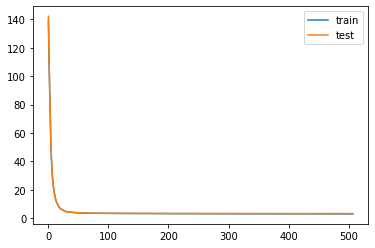

In [17]:
results = model.evals_result()
# plot learning curves
_train_results = np.array(list(map(math.exp,results['validation_0']['rmse'])))
_test_results = np.array(list(map(math.exp,results['validation_1']['rmse'])))
pyplot.plot(_train_results, label='train')
pyplot.plot(_test_results, label='test')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [18]:
y_pred = model.predict(x_test)

In [19]:
full_test['state'] = full_test.reset_index()['idx'].apply(lambda x: x.split("_")[0]).values

In [20]:
def perc_round(x):
    return round(x,-2)

full_test['pred'] = np.array(list(map(math.exp,y_pred)))
full_test['target_original'] = np.array(list(map(math.exp,full_test['target'])))
full_test['total_diff'] = np.array(list(map(round, full_test['target_original'] - full_test['pred'])))
full_test['perc_diff'] = full_test['total_diff'].values/full_test['target_original'].values

In [21]:
full_test.sample(15)

,target,1,2,3,4,0_1,0_2,0_3,0_4,1_1,1_2,1_3,1_4,state,pred,target_original,total_diff,perc_diff
idx,,,,,,,,,,,,,,,,,,
Michigan_25118,4.584967,4.418841,4.510860,4.532599,4.488636,0.575498,0.571357,0.568785,0.569463,0.452120,0.448292,0.443766,0.440798,Michigan,77.740206,98.0,20,0.204082
Florida_87808,3.258097,2.772589,3.218876,3.044522,3.610918,1.995818,1.953507,1.903172,1.856782,2.066368,2.009058,1.943417,1.885768,Florida,11.753703,26.0,14,0.538462
Indiana_51102,5.940171,6.267201,6.682109,6.580639,6.639876,0.136116,0.132698,0.129465,0.127967,-0.036773,-0.041149,-0.046395,-0.050199,Indiana,477.235119,380.0,-97,-0.255263
Oregon_82003,0.000000,0.000000,0.000000,0.000000,2.639057,-0.247577,-0.255544,-0.267782,-0.275603,-0.325517,-0.333836,-0.343687,-0.351790,Oregon,2.462330,1.0,-1,-1.000000
Maine_64417,3.871201,3.465736,3.784190,3.526361,3.951244,-0.700756,-0.701059,-0.701298,-0.700514,-0.673555,-0.674346,-0.675153,-0.675467,Maine,28.913679,48.0,19,0.395833
Maryland_69424,2.708050,2.639057,3.496508,3.912023,3.761200,0.032315,0.029745,0.028700,0.024860,-0.092436,-0.096964,-0.102183,-0.107372,Maryland,9.216011,15.0,6,0.400000
Tennessee_49329,3.135494,2.772589,2.639057,2.772589,0.000000,0.118073,0.107946,0.100679,0.094020,-0.006950,-0.015463,-0.024697,-0.032966,Tennessee,6.530844,23.0,16,0.695652
Massachusetts_43220,4.454347,4.060443,4.234107,3.737670,3.931826,0.131835,0.124759,0.120226,0.115174,0.031168,0.026617,0.021379,0.015915,Massachusetts,55.939808,86.0,30,0.348837
Michigan_71555,5.552960,5.533389,5.655992,5.472271,5.384495,0.575498,0.571357,0.568785,0.569463,0.452120,0.448292,0.443766,0.440798,Michigan,228.662074,258.0,29,0.112403


In [22]:
full_test.groupby(['state']).mean()

,target,1,2,3,4,0_1,0_2,0_3,0_4,1_1,1_2,1_3,1_4,pred,target_original,total_diff,perc_diff
state,,,,,,,,,,,,,,,,,
Alabama,4.731577,4.765754,4.876559,4.929091,4.888554,-0.162520,-0.162634,-0.162152,-0.162000,-0.236737,-0.240379,-0.244837,-0.248653,10266.016986,12181.742127,1915.737708,-161.552463
Alaska,4.016383,3.912151,3.786894,3.753294,3.586644,-0.738980,-0.738410,-0.739370,-0.739752,-0.786242,-0.786586,-0.787076,-0.787268,1693.482576,1963.029078,269.550532,-20.043188
American Samoa,3.545848,3.651175,3.699190,3.417921,3.271268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,228.238727,242.777778,14.444444,-0.672420
Arizona,5.010179,4.913235,4.866397,4.825870,4.738133,0.207604,0.196971,0.184604,0.173674,0.015564,-0.003810,-0.023994,-0.042012,11647.964731,13864.593295,2216.620528,-99.435952
Arkansas,4.516073,4.454019,4.460854,4.527186,4.479630,-0.422374,-0.423939,-0.425101,-0.426399,-0.489533,-0.491847,-0.494542,-0.496743,7069.489324,8524.247319,1454.789183,-125.163686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Virginia,4.957227,4.882367,4.849227,4.831726,4.852941,0.417973,0.410374,0.404800,0.398453,0.206701,0.197277,0.186812,0.176805,12706.275638,15244.817724,2538.529176,-227.199428
Washington,4.896520,4.807562,4.754399,4.743317,4.695378,0.311310,0.287503,0.263717,0.244507,0.062861,0.047921,0.031864,0.017852,8740.415348,10644.966846,1904.546248,-123.594843
West Virginia,4.187109,4.241998,4.272098,4.307053,4.304519,-0.626696,-0.623965,-0.621622,-0.620256,-0.614600,-0.613812,-0.613400,-0.613052,3335.849173,4011.929521,676.110423,-89.645306


In [23]:
excl_states =  ['Armed Forces Central/South America', 'Armed Forces Europe', 'Armed Forces Pacific', 'Foreign Country']

full_test.loc[~full_test['state'].isin(excl_states),:]

,target,1,2,3,4,0_1,0_2,0_3,0_4,1_1,1_2,1_3,1_4,state,pred,target_original,total_diff,perc_diff
idx,,,,,,,,,,,,,,,,,,
Alabama_00100,5.662960,5.690359,5.828946,5.899897,5.937536,-0.162520,-0.162634,-0.162152,-0.162000,-0.236737,-0.240379,-0.244837,-0.248653,Alabama,247.729919,288.0,40,0.138889
Alabama_00102,0.000000,0.000000,0.000000,5.036953,0.000000,-0.162520,-0.162634,-0.162152,-0.162000,-0.236737,-0.240379,-0.244837,-0.248653,Alabama,2.813114,1.0,-2,-2.000000
Alabama_00103,8.044305,8.012350,8.250620,8.189522,8.248006,-0.162520,-0.162634,-0.162152,-0.162000,-0.236737,-0.240379,-0.244837,-0.248653,Alabama,2803.760662,3116.0,312,0.100128
Alabama_00104,7.426549,7.807917,8.270269,8.133881,8.055475,-0.162520,-0.162634,-0.162152,-0.162000,-0.236737,-0.240379,-0.244837,-0.248653,Alabama,1803.219141,1680.0,-123,-0.073214
Alabama_00120,6.602588,6.708084,6.768493,6.687109,6.666957,-0.162520,-0.162634,-0.162152,-0.162000,-0.236737,-0.240379,-0.244837,-0.248653,Alabama,688.073382,737.0,49,0.066486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wyoming_Q5101,11.523865,10.509442,0.000000,0.000000,0.000000,-0.783313,-0.781783,-0.781225,-0.781926,-0.798589,-0.798755,-0.799054,-0.799364,Wyoming,18621.076621,101100.0,82479,0.815816
Wyoming_Q9957,4.330733,4.430817,3.401197,2.833213,0.000000,-0.783313,-0.781783,-0.781225,-0.781926,-0.798589,-0.798755,-0.799054,-0.799364,Wyoming,59.645544,76.0,16,0.210526
Wyoming_Q9965,3.433987,3.583519,4.553877,4.418841,4.709530,-0.783313,-0.781783,-0.781225,-0.781926,-0.798589,-0.798755,-0.799054,-0.799364,Wyoming,26.436546,31.0,5,0.161290


In [24]:
~full_test['state'].isin(excl_states)

idx
Alabama_00100    True
Alabama_00102    True
Alabama_00103    True
Alabama_00104    True
Alabama_00120    True
                 ... 
Wyoming_Q5101    True
Wyoming_Q9957    True
Wyoming_Q9965    True
Wyoming_Q9966    True
Wyoming_Q9967    True
Name: state, Length: 252862, dtype: bool

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f3594ae2-e1b0-4476-8420-ffda39dfce6e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>